<a href="https://colab.research.google.com/github/ermaury/k_brazos_AM_DE_JP/blob/main/P1/bandit_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estudio comparativo de algoritmos en un problema de k-armed bandit

*Description:* El experimento compara el rendimiento de algoritmos epsilon-greedy en un problema de k-armed bandit.
Se generan gráficas de recompensas promedio para cada algoritmo.

    Author: Luis Daniel Hernández Molinero
    Email: ldaniel@um.es
    Date: 2025/01/29

This software is licensed under the GNU General Public License v3.0 (GPL-3.0),
with the additional restriction that it may not be used for commercial purposes.

For more details about GPL-3.0: https://www.gnu.org/licenses/gpl-3.0.html



## Preparación del entorno


In [1]:
import os
import sys

# Comprobar si estamos en Google Colab
try:
    import google.colab
    EN_COLAB = True
except ImportError:
    EN_COLAB = False

if EN_COLAB:
    # Descargar el repositorio
    !git clone https://github.com/ermaury/k_brazos_AM_DE_JP.git

    # Cambiar al directorio de trabajo donde está P1
    repo_path = '/content/k_brazos_AM_DE_JP/P1'
    os.chdir(repo_path)

    # Confirmar cambio de directorio y añadir al path
    print("Directorio actual:", os.getcwd())
    sys.path.append(repo_path)

In [2]:
import numpy as np
from typing import List

from algorithms import Algorithm, EpsilonGreedy
from arms import ArmNormal, ArmBernouilli, ArmBinomial, ArmBeta, Bandit
from plotting import plot_average_rewards, plot_optimal_selections, plot_regret, plot_arm_statistics


semilla = 43

## Experimento

Cada algoritmo se ejecuta en un problema de k-armed bandit durante un número de pasos de tiempo y ejecuciones determinado.
Se comparan los resultados de los algoritmos en términos de recompensa promedio.

Por ejemplo. Dado un bandido de k-brazos, se ejecutan dos algoritmos epsilon-greedy con diferentes valores de epsilon. Se estudia la evolución de cada política  en un número de pasos, por ejemplo, mil pasos. Entonces se repite el experimento un número de veces, por ejemplo, 500 veces. Es decir, se ejecutan 500 veces la evolución de cada algoritmo en 1000 pasos. Para cada paso calculamos el promedio de las recoponensas obtenidas en esas 500 veces.

In [3]:
def run_experiment(bandit, algorithms: List, steps: int, runs: int):
    """
    Ejecuta experimentos con múltiples algoritmos sobre un bandit dado.

    :param bandit: Instancia de la clase Bandit.
    :param algorithms: Lista de instancias de algoritmos a evaluar.
    :param steps: Número de pasos de tiempo a simular.
    :param runs: Número de ejecuciones para promediar los resultados.
    
    :return: rewards, optimal_selections, regret_accumulated, arm_stats - 
             Matrices con recompensas, selecciones óptimas, regret acumulado y estadísticas de brazos.
    """

    optimal_arm = bandit.optimal_arm  # Índice del brazo óptimo
    optimal_reward = bandit.expected_rewards[optimal_arm]  # Recompensa esperada del brazo óptimo
    num_arms = len(bandit.arms)  # Número total de brazos

    rewards = np.zeros((len(algorithms), steps))  # Matriz para recompensas promedio
    optimal_selections = np.zeros((len(algorithms), steps))  # Matriz para selecciones óptimas
    regrets = np.zeros((len(algorithms), steps))  # Matriz para regret acumulado

    # Inicializar estadísticas de cada brazo por algoritmo
    arm_stats = [
        {
            'total_rewards': np.zeros(num_arms),  # Suma de recompensas por brazo
            'selections': np.zeros(num_arms),    # Veces que se seleccionó cada brazo
            'optimal_arm': optimal_arm,          # Guardar cuál es el brazo óptimo
        }
        for _ in range(len(algorithms))
    ]

    for run in range(runs):
        current_bandit = Bandit(arms=bandit.arms)  # Nueva instancia del bandit

        # Reiniciar los algoritmos
        for algo in algorithms:
            algo.reset()

        for step in range(steps):
            for idx, algo in enumerate(algorithms):
                chosen_arm = algo.select_arm()  # Seleccionar un brazo
                reward = current_bandit.pull_arm(chosen_arm)  # Obtener recompensa
                algo.update(chosen_arm, reward)  # Actualizar valores estimados

                rewards[idx, step] += reward  # Acumular recompensa

                # Si el brazo elegido es el óptimo, incrementar el contador
                if chosen_arm == optimal_arm:
                    optimal_selections[idx, step] += 1

                # Cálculo del regret instantáneo
                regret = optimal_reward - reward
                regrets[idx, step] += regret

                # Guardar estadísticas del brazo seleccionado
                arm_stats[idx]['total_rewards'][chosen_arm] += reward
                arm_stats[idx]['selections'][chosen_arm] += 1

    # Promediar los valores sobre el número de ejecuciones
    rewards /= runs
    optimal_selections = (optimal_selections / runs) * 100  # Convertir a porcentaje
    regrets /= runs  # Promediar regret acumulado

    # Calcular promedio de recompensas por brazo
    for idx in range(len(algorithms)):
        # Evitar divisiones por cero (si un brazo no fue seleccionado)
        mask = arm_stats[idx]['selections'] > 0
        arm_stats[idx]['avg_rewards'] = np.zeros(num_arms)
        arm_stats[idx]['avg_rewards'][mask] = arm_stats[idx]['total_rewards'][mask] / arm_stats[idx]['selections'][mask]
        
    return rewards, optimal_selections, regrets, arm_stats

## Ejecución del experimento

Se realiza el experimento usando 10 brazos, cada uno de acuerdo a varias distribuciones (Normal, Bernoulli y Binomial). Se realizan 500 ejecuciones de 1000 pasos cada una. Se contrastan 3 algoritmos epsilon greedy para valores epsilon: 0.0, 0.01, y 0.1.

In [4]:
# Parámetros del experimento
np.random.seed(semilla)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

arms = [ArmNormal, ArmBernouilli, ArmBinomial]


# Creación del bandit
bandits = [Bandit(arms=arm.generate_arms(k)) for arm in arms]

results = dict()

for bandit in bandits:
    print(f"Executing Bandit with arm type {bandit.get_type_arms()}")
    
    optimal_arm = bandit.optimal_arm
    print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")
    
    # Definir los algoritmos a comparar. En este caso son 3 algoritmos epsilon-greedy con diferentes valores de epsilon.
    algorithms = [EpsilonGreedy(k=k, epsilon=0), EpsilonGreedy(k=k, epsilon=0.01), EpsilonGreedy(k=k, epsilon=0.1)]
    
    # Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
    rewards, optimal_selections, regret_accumulated, arm_stats = run_experiment(bandit, algorithms, steps=1000, runs=500)

    results[bandit.get_type_arms()] = (rewards, optimal_selections, regret_accumulated, arm_stats)

    # Calcular la recompensa media total para cada algoritmo
    mean_rewards = rewards.mean(axis=1)

    print("\nRecompensas medias por algoritmo:")
    for algo, mean_reward in zip(algorithms, mean_rewards):
        print(f"{algo.get_algorithm_label()}: {mean_reward:.3f}")
    print("\n" + "-"*50)

Executing Bandit with arm type ArmNormal
Optimal arm: 8 with expected reward=8.73

Recompensas medias por algoritmo:
EpsilonGreedy (epsilon=0): 1.343
EpsilonGreedy (epsilon=0.01): 6.629
EpsilonGreedy (epsilon=0.1): 8.096

--------------------------------------------------
Executing Bandit with arm type ArmBernouilli
Optimal arm: 5 with expected reward=0.8666486408992002

Recompensas medias por algoritmo:
EpsilonGreedy (epsilon=0): 0.395
EpsilonGreedy (epsilon=0.01): 0.687
EpsilonGreedy (epsilon=0.1): 0.788

--------------------------------------------------
Executing Bandit with arm type ArmBinomial
Optimal arm: 10 with expected reward=11.738449608984073

Recompensas medias por algoritmo:
EpsilonGreedy (epsilon=0): 3.348
EpsilonGreedy (epsilon=0.01): 8.469
EpsilonGreedy (epsilon=0.1): 10.653

--------------------------------------------------


In [5]:
rewards_normal, optimal_selections_normal, regret_accumulated_normal, arm_stats_normal = results['ArmNormal']
rewards_bernouilli, optimal_selections_bernouilli, regret_accumulated_bernouilli, arm_stats_bernouilli = results['ArmBernouilli']
rewards_binomial, optimal_selections_binomial, regret_accumulated_binomial, arm_stats_binomial = results['ArmBinomial']

## Visualización de los resultados (Distribución Normal)

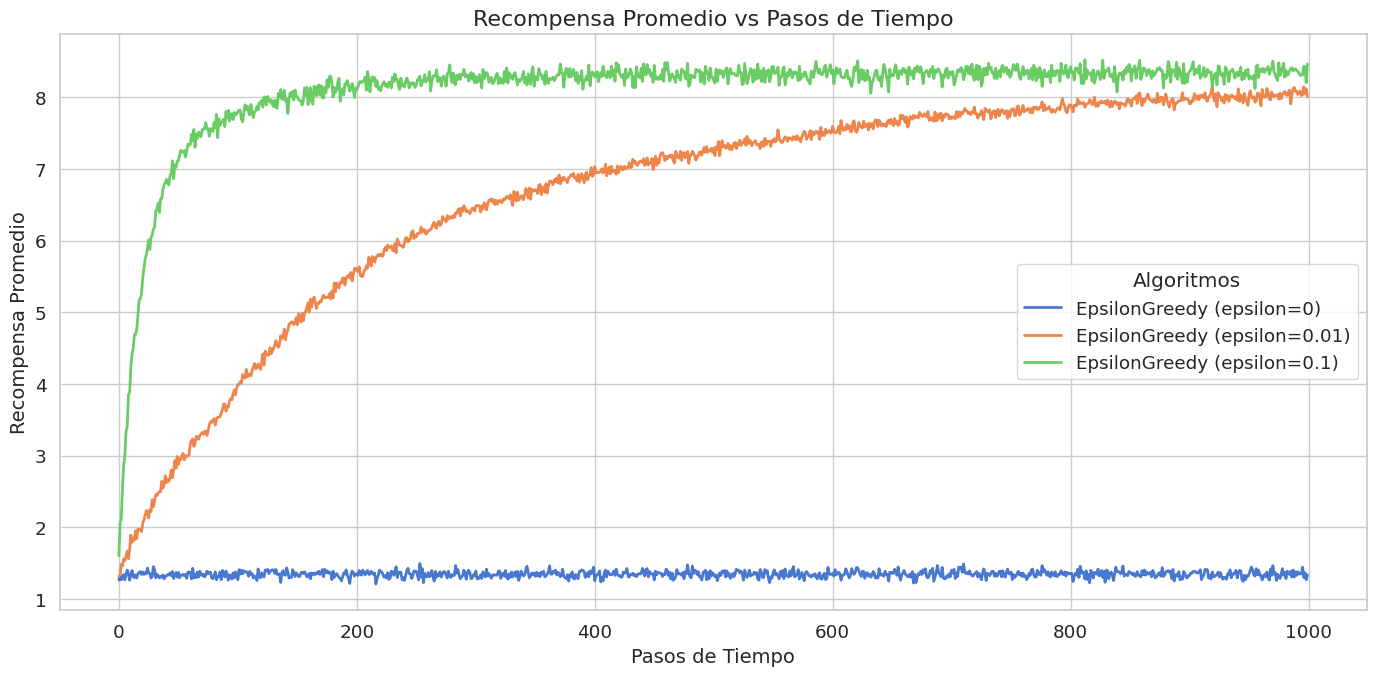

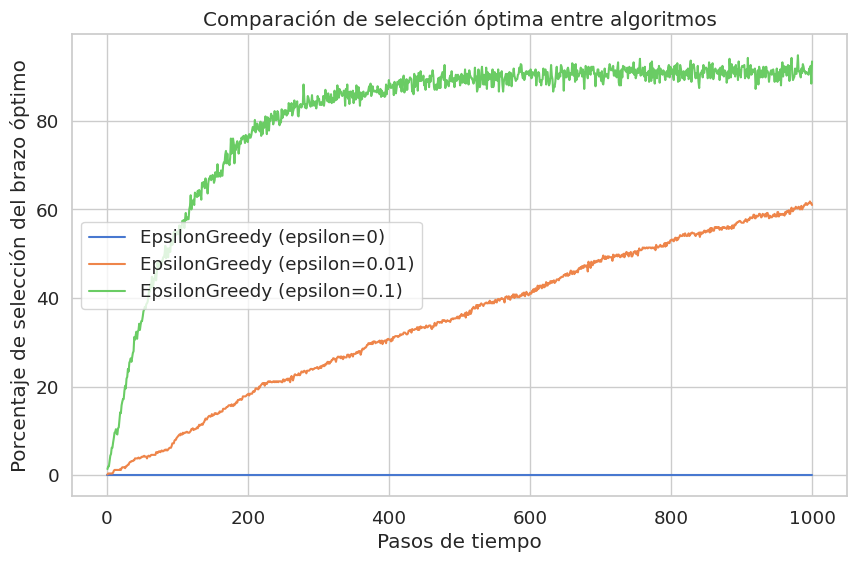

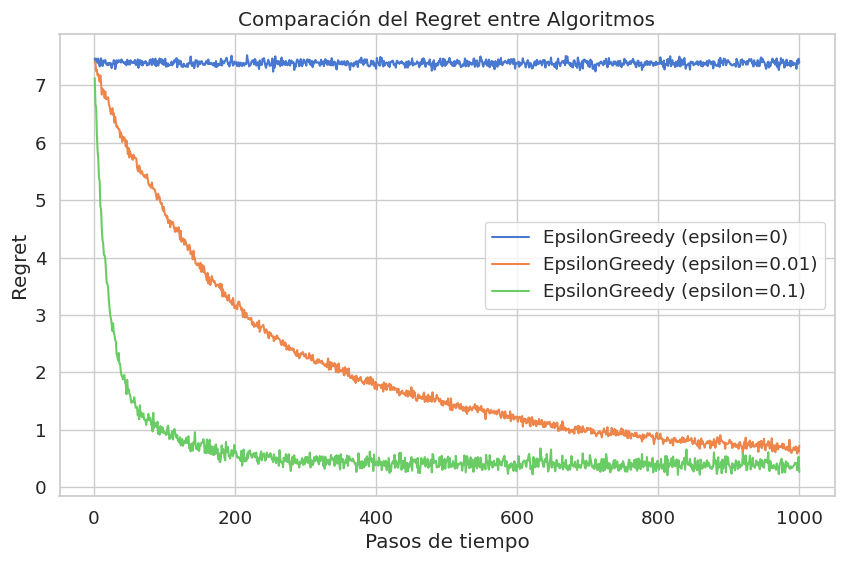

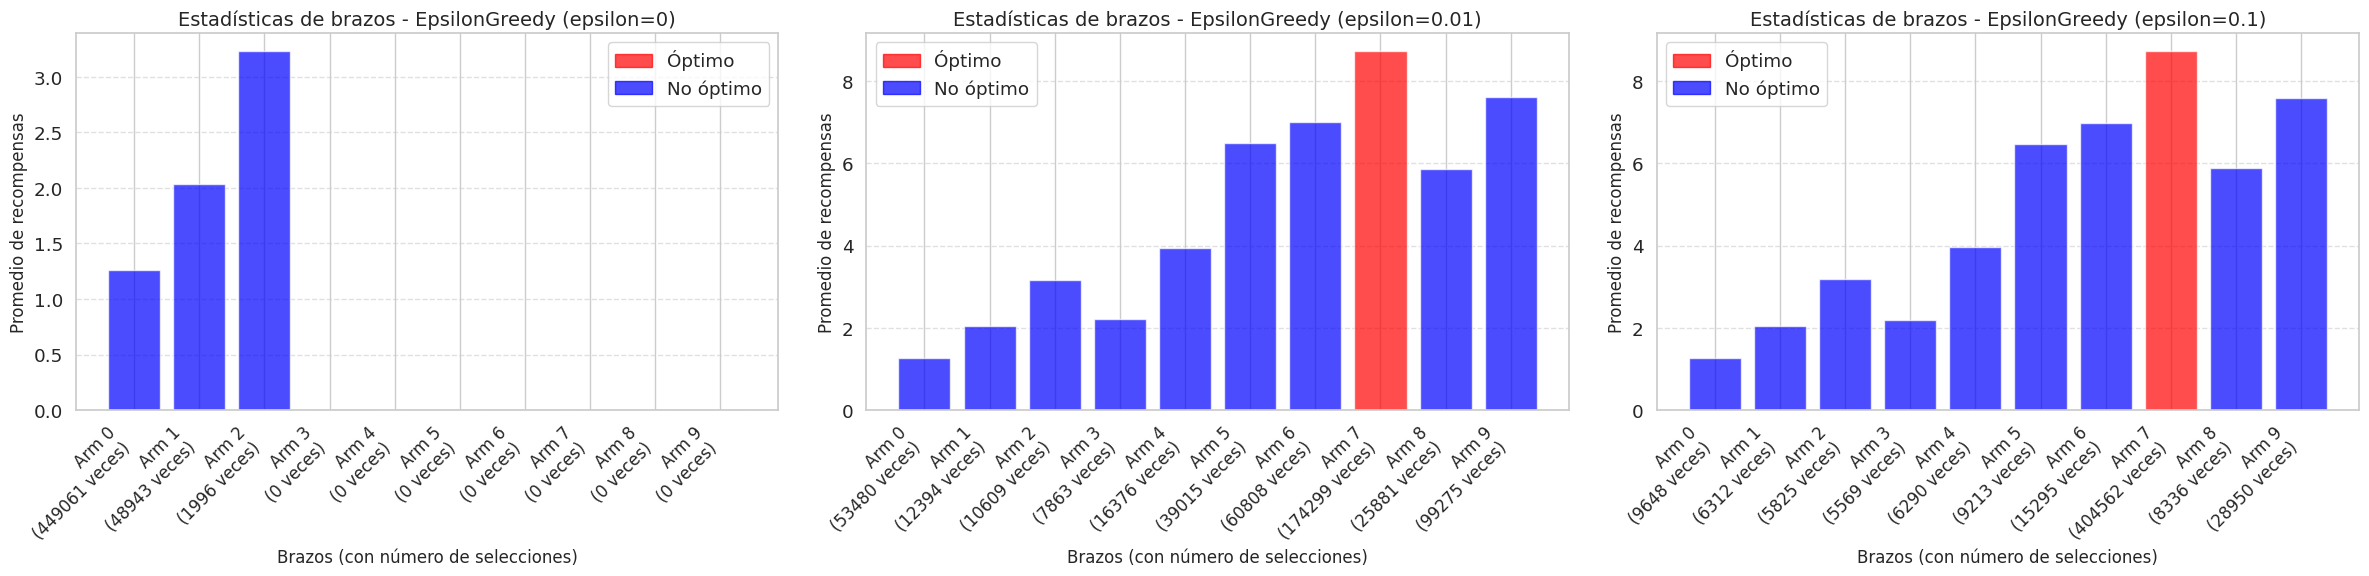

In [6]:
# Graficar los resultados
plot_average_rewards(steps, rewards_normal, algorithms)
plot_optimal_selections(steps, optimal_selections_normal, algorithms)
plot_regret(steps, regret_accumulated_normal, algorithms)
plot_arm_statistics(arm_stats_normal, algorithms)

### Recompensa Promedio vs Pasos de Tiempo

- **Epsilon = 0**: la recompensa promedio se mantiene baja (alrededor de 1.5). El algoritmo queda atrapado en un brazo subóptimo desde el principio, sin posibilidad de mejora al no haber exploración.
- **Epsilon = 0.01**: la recompensa promedio aumenta gradualmente hasta alcanzar aproximadamente una recompensa de 8. Aunque la exploración es muy limitada, permite eventualmente descubrir el brazo óptimo.
- **Epsilon = 0.1**: la recompensa promedio crece rápidamente y alcanza valores de recompensa mayores de 8. El nivel de exploración más alto favorece una rápida identificación del mejor brazo.

Esta gráfica demuestra que incluso una pequeña cantidad de exploración permite mejorar significativamente el aprendizaje.

---

### Porcentaje de Selección del Brazo Óptimo

- **Epsilon = 0**: el porcentaje de selección del óptimo se mantiene en 0%. El algoritmo nunca encuentra el mejor brazo.
- **Epsilon = 0.01**: el porcentaje aumenta progresivamente hasta cerca del 60%. El algoritmo va aprendiendo a seleccionar el mejor brazo, aunque de forma lenta.
- **Epsilon = 0.1**: el porcentaje sube rápidamente y se estabiliza en torno al 90%. El algoritmo converge rápidamente al óptimo.

Esta gráfica refleja la capacidad del algoritmo para identificar y centrarse en el brazo óptimo conforme avanza el tiempo.

---

### Regret Acumulado vs Pasos de Tiempo

- **Epsilon = 0**: el regret se mantiene alto y constante (alrededor de 8). La falta de exploración impide corregir malas decisiones iniciales.
- **Epsilon = 0.01**: el regret disminuye gradualmente a lo largo del tiempo. A medida que el algoritmo encuentra el óptimo, el coste por no haberlo elegido se reduce.
- **Epsilon = 0.1**: el regret disminuye rápidamente hacia cero. El algoritmo aprende rápido y minimiza las decisiones equivocadas.

El regret acumulado proporciona una medida clara del coste de no haber explorado suficientemente.

---

### Estadísticas de Selección y Recompensa por Brazo

- **Epsilon = 0**: solo se seleccionan tres brazos, ninguno de los cuales es el óptimo. Esto confirma que el algoritmo se quedó estancado en elecciones iniciales sin exploración.
- **Epsilon = 0.01**: se observa cierta exploración. Todos los brazos fueron seleccionados, aunque con diferente frecuencia. El brazo óptimo fue eventualmente descubierto y es el más utilizado.
- **Epsilon = 0.1**: la distribución de selecciones es más dispersa, pero el óptimo es claramente el más seleccionado. Se observa un buen equilibrio entre exploración y explotación.

Estas gráficas permiten analizar visualmente cuántas veces fue seleccionado cada brazo y con qué recompensa promedio, ayudando a interpretar el comportamiento del algoritmo.

---

### Conclusión

La comparación muestra que:

- La configuración `epsilon = 0` puede fallar por completo si el mejor brazo no es el primero que se prueba.
- Un valor pequeño de `epsilon` permite aprender, aunque lentamente.
- Un `epsilon` moderado garantiza una buena exploración inicial que se traduce en un rápido aprendizaje y baja pérdida acumulada.

Esto evidencia la importancia de incluir un mínimo de exploración en entornos inciertos para evitar soluciones subóptimas permanentes.


## Visualización de los resultados (Distribución Bernouilli)

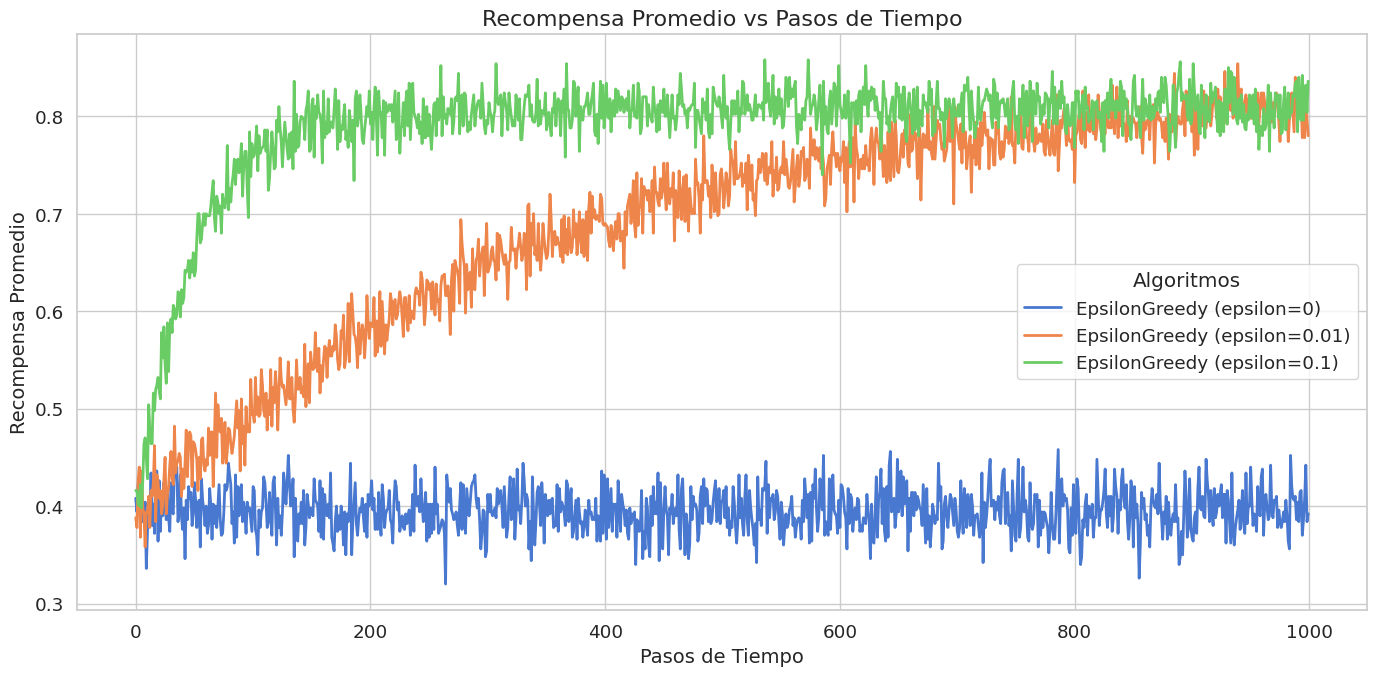

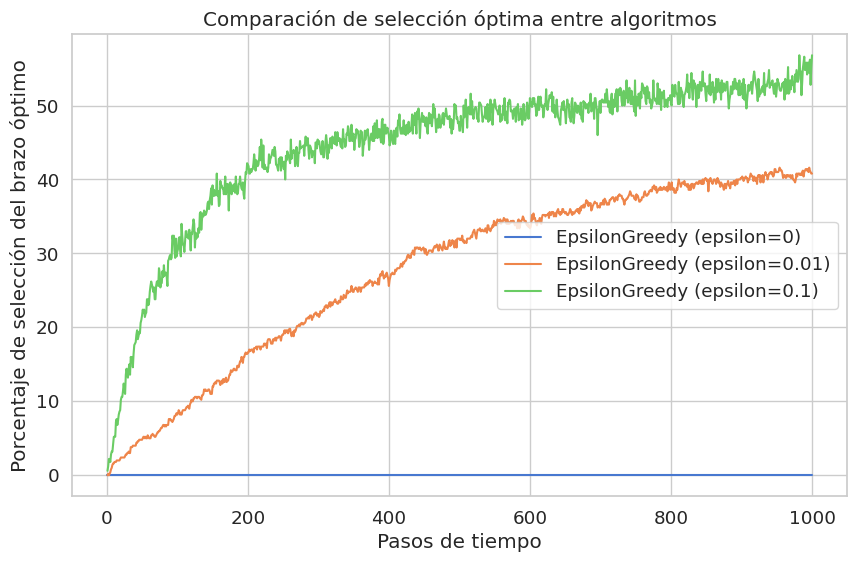

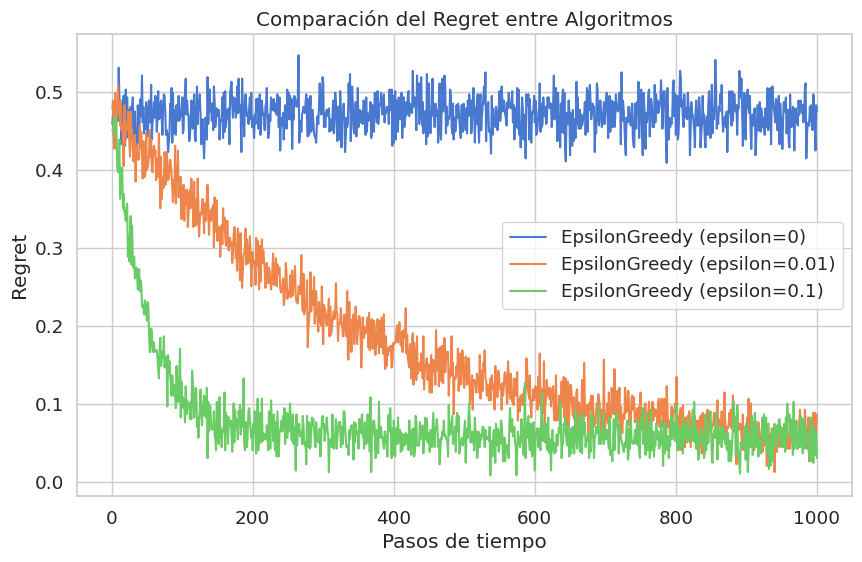

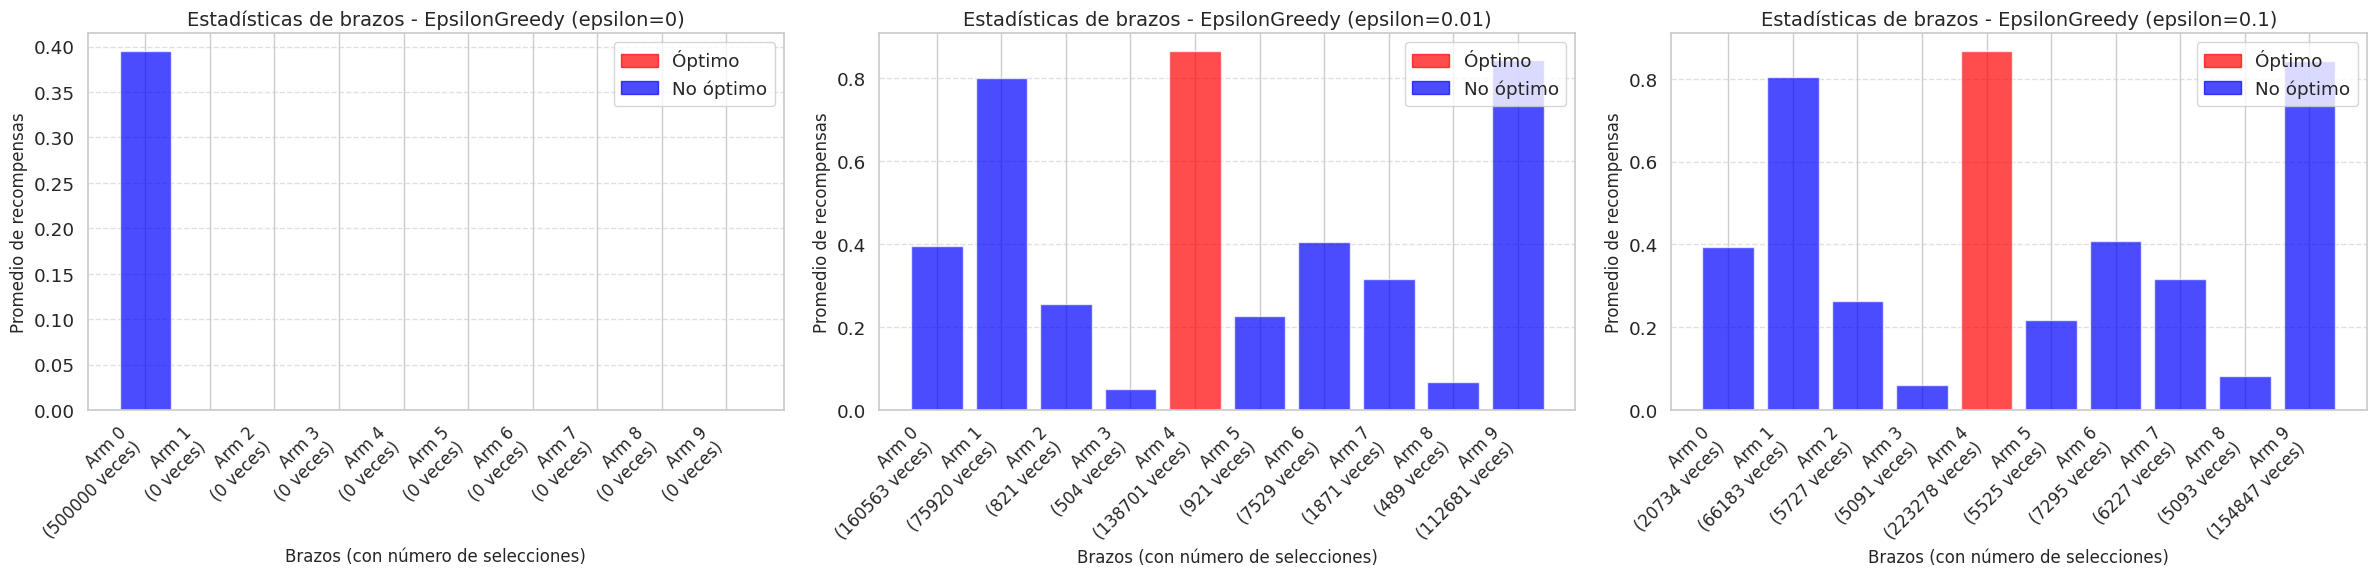

In [7]:
# Graficar los resultados
plot_average_rewards(steps, rewards_bernouilli, algorithms)
plot_optimal_selections(steps, optimal_selections_bernouilli, algorithms)
plot_regret(steps, regret_accumulated_bernouilli, algorithms)
plot_arm_statistics(arm_stats_bernouilli, algorithms)

### Recompensa Promedio vs Pasos de Tiempo

- **Epsilon = 0**: la recompensa promedio se mantiene constante alrededor de 0.4. Esto indica que el algoritmo quedó atascado en un brazo subóptimo desde el principio y no exploró más.
- **Epsilon = 0.01**: el rendimiento mejora progresivamente, alcanzando una recompensa promedio cercana a 0.8. La exploración ocasional permitió encontrar mejores brazos.
- **Epsilon = 0.1**: la curva sube más rápido y alcanza una recompensa promedio superior a 0.8. Se demuestra un buen equilibrio entre exploración y explotación.

Este gráfico muestra claramente que **el nivel de exploración afecta fuertemente la calidad de las decisiones**, especialmente si la inicialización es desfavorable.

---

### Porcentaje de Selección del Brazo Óptimo

- **Epsilon = 0**: el óptimo no se selecciona nunca. El algoritmo quedó atrapado con el primer brazo probado.
- **Epsilon = 0.01**: la selección del óptimo crece lentamente hasta estabilizarse alrededor del 40%.
- **Epsilon = 0.1**: el porcentaje de selección del óptimo supera el 50% y continúa creciendo con el tiempo.

Esta gráfica confirma que, sin exploración, el algoritmo puede fallar completamente. La exploración, aunque mínima, mejora sustancialmente la probabilidad de converger hacia el mejor brazo.

---

### Regret Acumulado vs Pasos de Tiempo

- **Epsilon = 0**: el regret se mantiene alto y constante. No hay aprendizaje ni mejora.
- **Epsilon = 0.01**: el regret decrece con el tiempo, reflejando una mejora progresiva.
- **Epsilon = 0.1**: el regret baja rápidamente y se mantiene en niveles muy bajos.

Esto demuestra que la exploración no solo permite identificar el óptimo, sino también **minimizar el coste acumulado de las decisiones subóptimas**.

---

### Estadísticas de Selección y Recompensa por Brazo

- **Epsilon = 0**:
  - Solo se seleccionó un brazo (Arm 0) que no era el óptimo.
  - Todos los demás brazos no fueron explorados.
  - La recompensa promedio se quedó en un valor bajo.

- **Epsilon = 0.01**:
  - El óptimo (Arm 4) fue identificado como el mejor aunque no fue el más seleccionado.
  - Hubo exploración moderada del resto de brazos.
  - Se alcanzó un equilibrio razonable entre exploración y explotación.

- **Epsilon = 0.1**:
  - El óptimo es el más seleccionado, pero otros brazos también se probaron con más frecuencia.
  - La distribución de selecciones es más dispersa debido al mayor valor de `epsilon`.

Estas gráficas complementan la información dinámica de las curvas anteriores con una visión global del comportamiento final de cada política.

---

### Conclusión

Este experimento demuestra que, en el caso de **distribuciones Bernoulli** (en este caso, varios brazos tienen promedios cercanos al óptimo), el valor de `epsilon` tiene un impacto significativo en el rendimiento, especialmente cuando el entorno es menos favorable:

- `epsilon = 0` puede funcionar solo si el óptimo se descubre de inmediato, lo cual depende del azar.
- `epsilon = 0.01` ofrece una mejora clara y robusta.
- `epsilon = 0.1` proporciona el mejor rendimiento general gracias a una exploración más activa.

## Visualización de los resultados (Distribución Binomial)

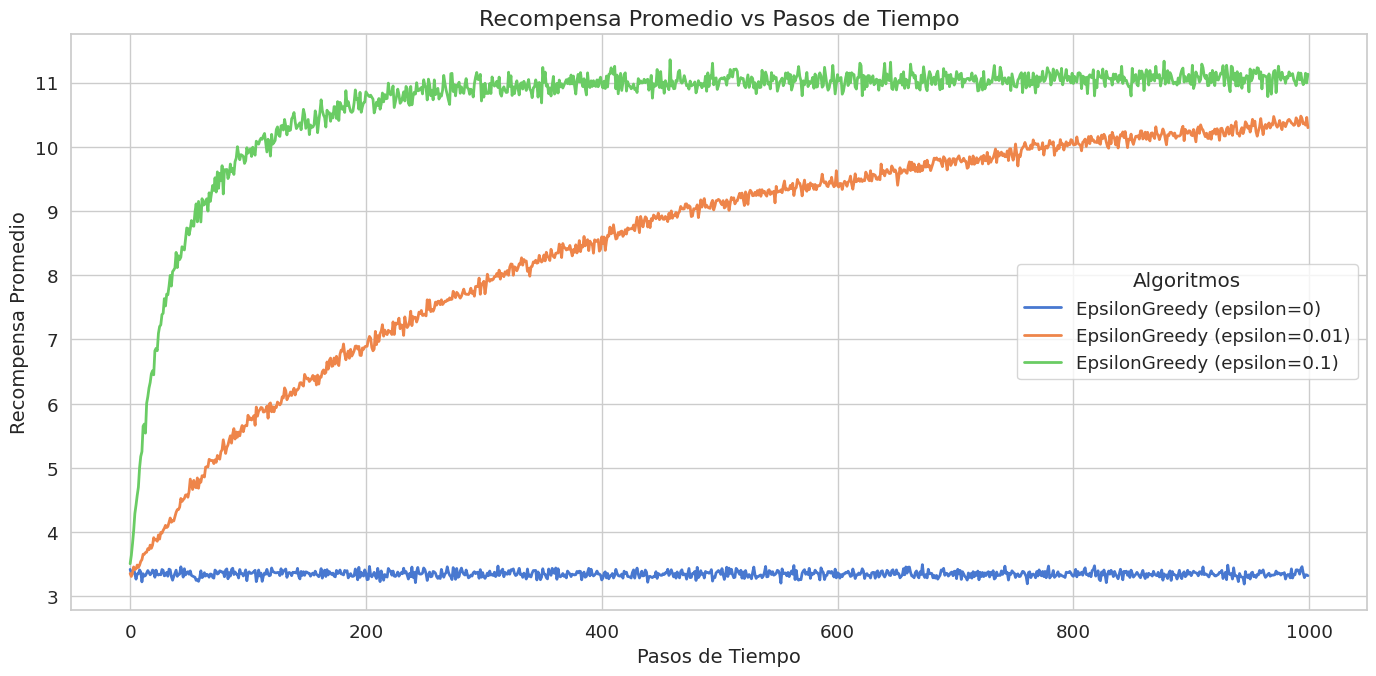

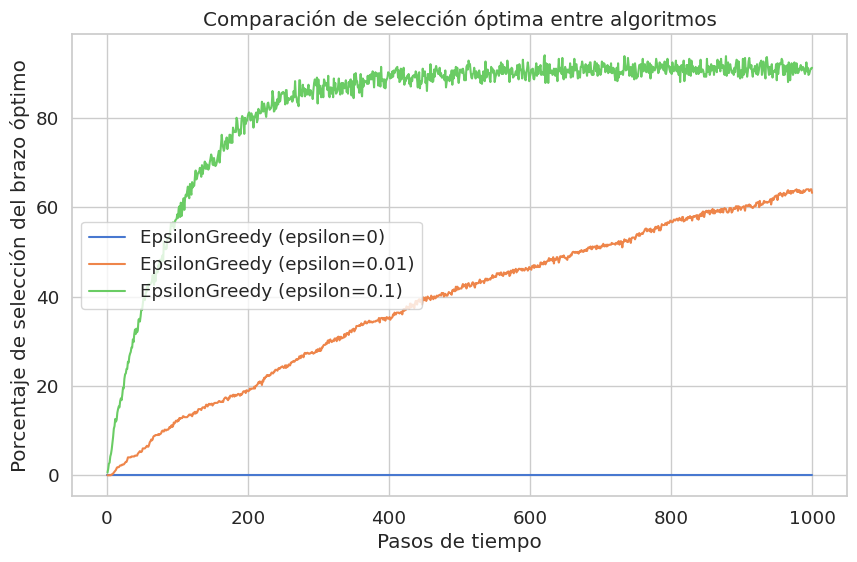

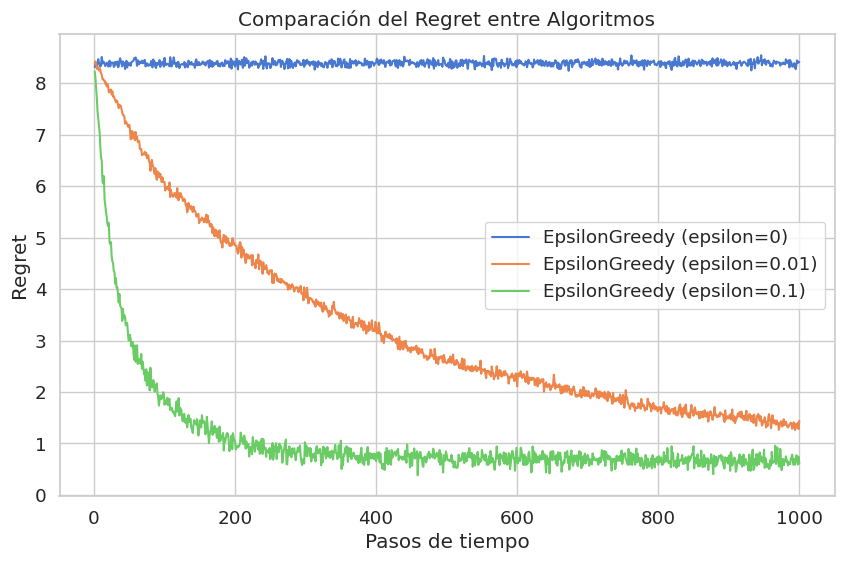

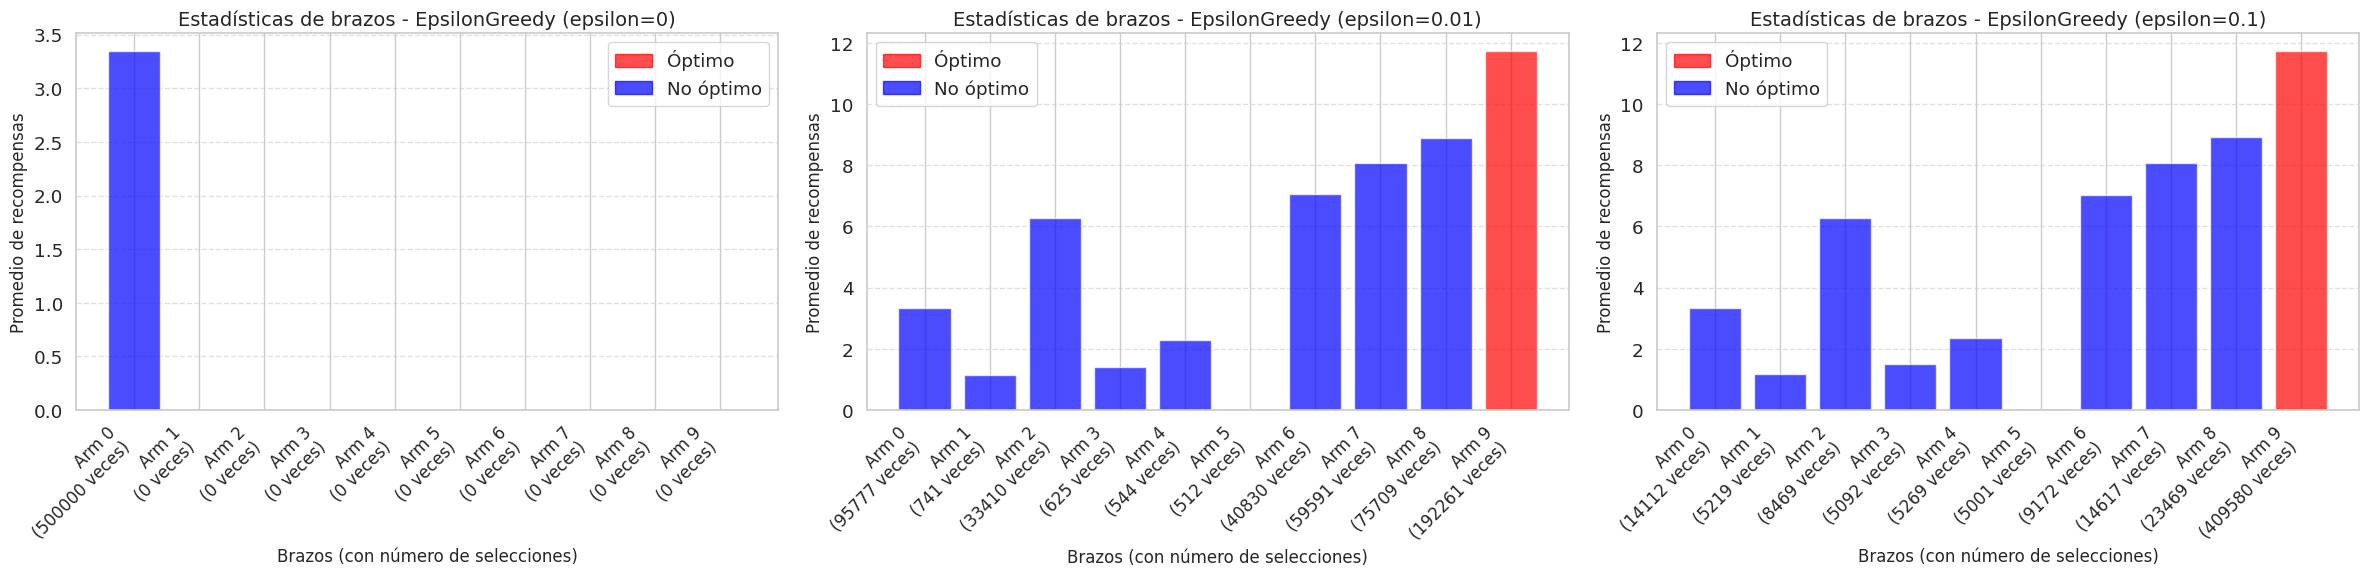

In [8]:
# Graficar los resultados
plot_average_rewards(steps, rewards_binomial, algorithms)
plot_optimal_selections(steps, optimal_selections_binomial, algorithms)
plot_regret(steps, regret_accumulated_binomial, algorithms)
plot_arm_statistics(arm_stats_binomial, algorithms)

### Recompensa Promedio vs Pasos de Tiempo

- **Epsilon = 0**: el valor se mantiene constante alrededor de 3.4, lo que indica que el algoritmo eligió un brazo subóptimo desde el inicio y nunca exploró otros.
- **Epsilon = 0.01**: la recompensa promedio crece progresivamente y alcanza valores superiores a 10. Esto indica que el algoritmo encontró el óptimo y comenzó a explotarlo.
- **Epsilon = 0.1**: el crecimiento es más rápido que en el caso anterior, alcanzando una recompensa media superior a 11, lo que implica una mejor exploración y rápida convergencia al mejor brazo.

La distribución binomial permite diferencias más marcadas entre brazos, por lo que el valor esperado del óptimo puede ser mucho mayor. Esto se refleja en las curvas.

---

### Porcentaje de Selección del Brazo Óptimo

- **Epsilon = 0**: el óptimo no se selecciona nunca (0%), lo que confirma que el algoritmo quedó atrapado en una mala elección inicial.
- **Epsilon = 0.01**: la selección del óptimo sube lentamente hasta superar el 60%.
- **Epsilon = 0.1**: el porcentaje sube más rápido y se estabiliza cerca del 90%, indicando una identificación y explotación efectiva del brazo óptimo.

Este gráfico muestra cómo un mayor `epsilon` favorece una convergencia más temprana al óptimo, especialmente importante cuando hay mucha varianza en las recompensas.

---

### Regret Acumulado vs Pasos de Tiempo

- **Epsilon = 0**: el regret se mantiene alto (~8) durante toda la ejecución.
- **Epsilon = 0.01**: el regret decrece lentamente, demostrando una mejora gradual.
- **Epsilon = 0.1**: el regret baja muy rápidamente y se estabiliza en niveles muy bajos.

Esto refuerza la conclusión de que explorar ayuda a minimizar el coste acumulado de no elegir el óptimo.

---

### Estadísticas de Selección y Recompensa por Brazo

- **Epsilon = 0**:
  - Solo se seleccionó el primer brazo (Arm 0), que no era el óptimo.
  - El valor esperado de recompensa es bajo (~3.4).
  - Todos los demás brazos fueron completamente ignorados.

- **Epsilon = 0.01**:
  - El brazo óptimo (Arm 9) fue identificado como el mejor y se seleccionó con frecuencia.
  - El resto de brazos también fueron explorados, aunque mucho menos.

- **Epsilon = 0.1**:
  - El óptimo (Arm 9) fue seleccionado más veces que cualquier otro brazo.
  - La exploración fue más activa, lo cual permitió evaluar más exhaustivamente todos los brazos.
  - Se observa una mejor explotación del óptimo con menor regret.

Estas gráficas muestran cómo cambia el equilibrio entre exploración y explotación según el valor de `epsilon`.

---

### Conclusión

La distribución binomial introduce más variabilidad y mayor separación entre brazos en términos de recompensa esperada. Esto exige una política de exploración más activa.

- **Sin exploración**, el algoritmo puede quedar completamente atrapado en un brazo subóptimo.
- **Con exploración baja (0.01)**, se identifica gradualmente el óptimo.
- **Con exploración moderada (0.1)**, se encuentra el óptimo rápidamente y se maximiza la recompensa acumulada.

## Conclusión general

Incluso pequeñas cantidades de exploración ($\varepsilon=0.01$) mejoran notablemente frente a greedy puro. Para entornos ruidosos, $\varepsilon=0.1$ ofreció el mejor rendimiento global.